In [1]:
import pandas as pd
import ast


In [2]:
file_path = '../pred_visualiser/input_tsvs/dear_cpu_f1_reward_2epoch-3.tsv'

with open(file_path, 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    if line.strip():
        # Remove the 'span2semantic' field using string manipulation
        line_mod = line
        # Find the start and end of the 'span2semantic' field
        start = line_mod.find("'span2semantic':")
        if start != -1:
            # Find the comma after the field to remove it cleanly
            end = line_mod.find("},", start)
            if end != -1:
                # Remove the field including the trailing comma
                line_mod = line_mod[:start] + line_mod[end+2:]
            else:
                # If it's the last field, remove up to the closing brace
                end = line_mod.find("}", start)
                line_mod = line_mod[:start] + line_mod[end+1:]
        # Parse the modified line
        data.append(ast.literal_eval(line_mod))

df = pd.DataFrame(data)


In [3]:
df.head()  # Display the first few rows of the DataFrame

,bottom_idx,pre_semantic_edges,pred_edges,gold_edges,pair,comp reward,solv reward,category
0,"[1, 4, 5, 7, 9]","[(5, 4, agent), (1, 5, relcl), (1, 7, relcl), ...","[[like, cat, agent], [cake, like, relcl], [cak...","[[cake, like, relcl], [like, cat, agent], [lik...",[the cake that a cat liked was eaten by elizab...,0.727273,0.75,RC_modif_subj
1,"[1, 4, 5, 8, 11, 14, 16, 18, 21]","[(18, 21, beside), (16, 18, theme), (11, 16, r...","[[cake, machine, beside], [mail, cake, theme],...","[[bird, room, in], [like, bird, agent], [like,...",[a bird in the room liked that a girl in the t...,0.444444,1.00,PP_modif_subj
2,"[0, 3, 6, 7]","[(3, 6, beside), (3, 7, relcl), (0, 3, on)]","[[teacher, shoe, beside], [teacher, grow, relc...","[[teacher, shoe, beside], [grow, teacher, agen...","[who did the teacher beside the shoe grow ?, *...",0.571429,0.50,Q_modified_NPs
3,"[1, 2, 4, 5, 7, 10, 13, 15, 18]","[(15, 18, beside), (10, 15, in), (13, 10, on),...","[[donut, valve, beside], [road, donut, in], [c...","[[prove, dog, agent], [prove, give, ccomp], [g...",[a dog proved that charlotte gave the servant ...,0.470588,1.00,PP_modif_iobj
4,"[1, 3, 4, 6, 7]","[(3, 6, theme), (3, 4, recipient), (3, 7, ccom...","[[send, donut, theme], [send, emma, recipient]...","[[mouse, send, relcl], [send, mouse, agent], [...","[a mouse that sent emma a donut burned, mouse ...",0.800000,1.00,RC_modif_subj


In [49]:
# Separate CP, PP, and center_embed_5-12 categories
df_cp = df[df['category'] == 'CP_5-12'].copy()
df_pp = df[df['category'] == 'PP_5-12'].copy()
df_center = df[df['category'] == 'center_embed_5-12'].copy()

# For CP: count "that" in the first element of "pair"
df_cp['rec_count'] = df_cp['pair'].apply(lambda x: x[0].count('that'))

# For PP: count " in ", " on ", and "beside" in the first element of "pair"
def count_pp_preps(s):
    return s.count(' in ') + s.count(' on ') + s.count('beside')

df_pp['rec_count'] = df_pp['pair'].apply(lambda x: count_pp_preps(x[0]))

# For center_embed_5-12: count "that" in the first element of "pair"
df_center['rec_count'] = df_center['pair'].apply(lambda x: x[0].count('that'))

# For all: create "correct" field
df_cp['correct'] = (df_cp['comp reward'] == 1) & (df_cp['solv reward'] == 1)
df_pp['correct'] = (df_pp['comp reward'] == 1) & (df_pp['solv reward'] == 1)
df_center['correct'] = (df_center['comp reward'] == 1) & (df_center['solv reward'] == 1)

# Print proportions for CP
print("CP_5-12 proportions:")
print(df_cp.groupby('rec_count')['correct'].value_counts(normalize=True).unstack().fillna(0))
print("Mean comp reward by rec_count:")
print(df_cp.groupby('rec_count')['comp reward'].mean())
print("Mean solv reward by rec_count:")
print(df_cp.groupby('rec_count')['solv reward'].mean())

# Print proportions for PP
print("\nPP_5-12 proportions:")
print(df_pp.groupby('rec_count')['correct'].value_counts(normalize=True).unstack().fillna(0))
print("Mean comp reward by rec_count:")
print(df_pp.groupby('rec_count')['comp reward'].mean())
print("Mean solv reward by rec_count:")
print(df_pp.groupby('rec_count')['solv reward'].mean())

# Print proportions for center_embed_5-12
print("\ncenter_embed_5-12 proportions:")
print(df_center.groupby('rec_count')['correct'].value_counts(normalize=True).unstack().fillna(0))
print("Mean comp reward by rec_count:")
print(df_center.groupby('rec_count')['comp reward'].mean())
print("Mean solv reward by rec_count:")
print(df_center.groupby('rec_count')['solv reward'].mean())


CP_5-12 proportions:
correct    False  True 
rec_count              
5          0.296  0.704
6          0.408  0.592
7          0.696  0.304
8          0.888  0.112
9          0.936  0.064
10         0.976  0.024
11         0.992  0.008
12         0.992  0.008
Mean comp reward by rec_count:
rec_count
5     0.925166
6     0.880284
7     0.807697
8     0.715872
9     0.665934
10    0.695842
11    0.646546
12    0.609394
Name: comp reward, dtype: float64
Mean solv reward by rec_count:
rec_count
5     0.986173
6     0.992886
7     0.991234
8     0.991368
9     0.995017
10    0.990815
11    0.996227
12    0.996083
Name: solv reward, dtype: float64

PP_5-12 proportions:
correct    False  True 
rec_count              
5          0.064  0.936
6          0.088  0.912
7          0.312  0.688
8          0.600  0.400
9          0.792  0.208
10         0.984  0.016
11         0.984  0.016
12         0.992  0.008
Mean comp reward by rec_count:
rec_count
5     0.989533
6     0.977364
7     0.909419
8

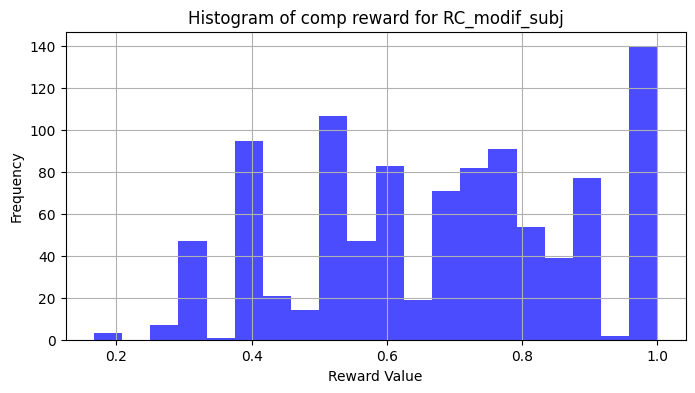

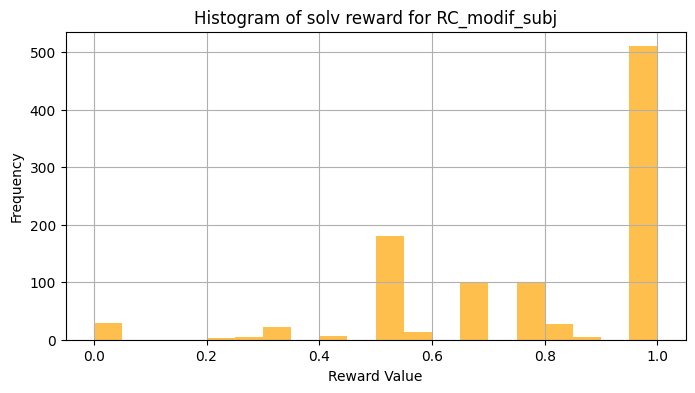

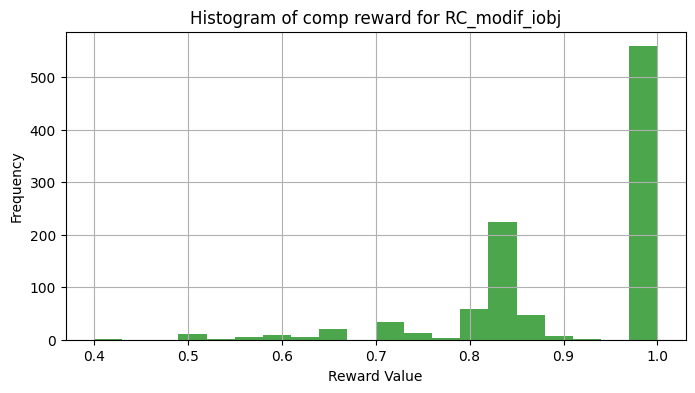

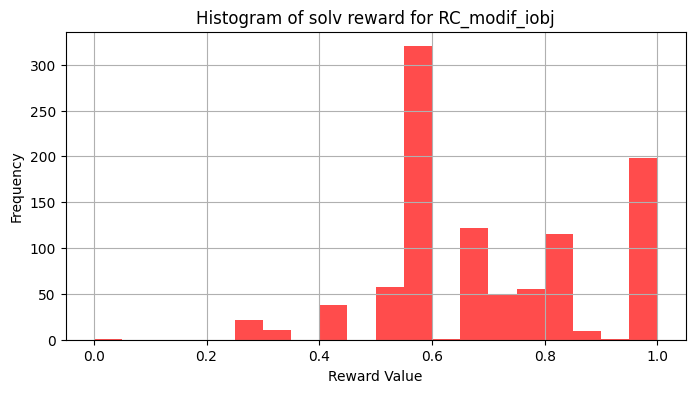

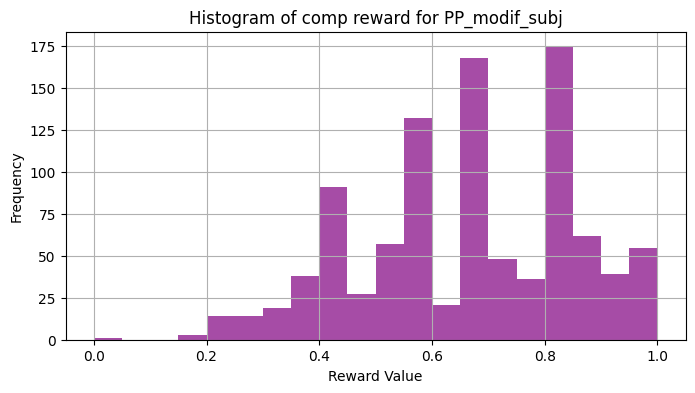

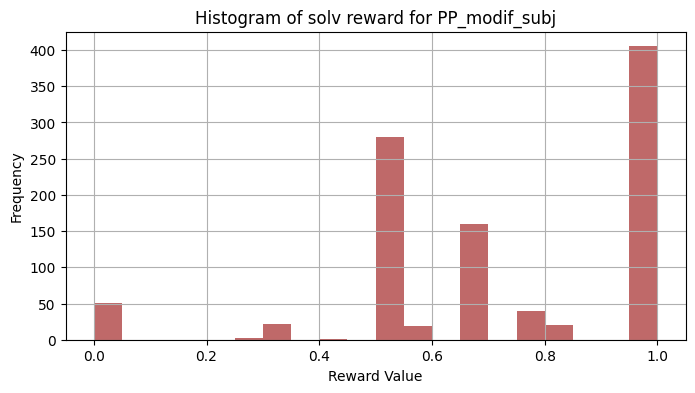

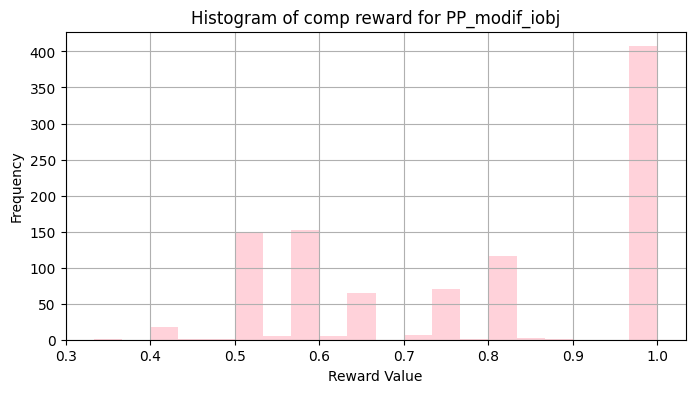

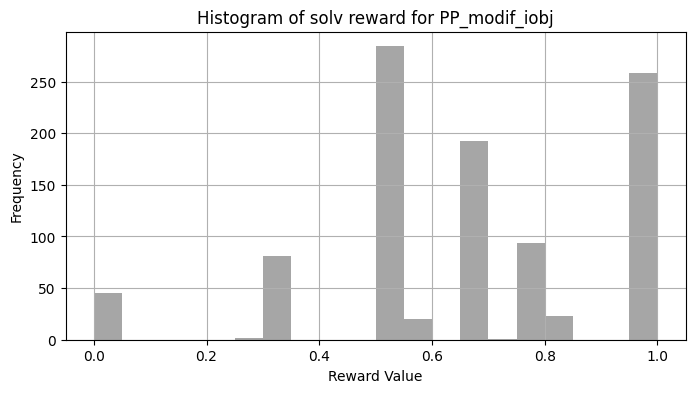


RC_modif_subj proportions:
Comp Reward == 1: 0.14
Solv Reward == 1: 0.51

RC_modif_iobj proportions:
Comp Reward == 1: 0.559
Solv Reward == 1: 0.198

PP_modif_subj proportions:
Comp Reward == 1: 0.055
Solv Reward == 1: 0.405

PP_modif_iobj proportions:
Comp Reward == 1: 0.407
Solv Reward == 1: 0.258


In [51]:
# Now, create dfs with the following categories: "RC_modif_subj", "RC_modif_iobj", "PP_modif_subj", "PP_modif_iobj"
df_rc_modif_subj = df[df['category'] == 'RC_modif_subj'].copy()
df_rc_modif_iobj = df[df['category'] == 'RC_modif_iobj'].copy()
df_pp_modif_subj = df[df['category'] == 'PP_modif_subj'].copy()
df_pp_modif_iobj = df[df['category'] == 'PP_modif_iobj'].copy()

import matplotlib.pyplot as plt

# Plot separate histograms for comp reward and solv reward for each category
def plot_single_histogram(df, column, category_name, color):
    plt.figure(figsize=(8, 4))
    plt.hist(df[column], bins=20, alpha=0.7, color=color)
    plt.title(f'Histogram of {column} for {category_name}')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_single_histogram(df_rc_modif_subj, 'comp reward', 'RC_modif_subj', 'blue')
plot_single_histogram(df_rc_modif_subj, 'solv reward', 'RC_modif_subj', 'orange')
plot_single_histogram(df_rc_modif_iobj, 'comp reward', 'RC_modif_iobj', 'green')
plot_single_histogram(df_rc_modif_iobj, 'solv reward', 'RC_modif_iobj', 'red')
plot_single_histogram(df_pp_modif_subj, 'comp reward', 'PP_modif_subj', 'purple')
plot_single_histogram(df_pp_modif_subj, 'solv reward', 'PP_modif_subj', 'brown')
plot_single_histogram(df_pp_modif_iobj, 'comp reward', 'PP_modif_iobj', 'pink')
plot_single_histogram(df_pp_modif_iobj, 'solv reward', 'PP_modif_iobj', 'gray')

# print the proportion of rows with comp reward == 1 and solv reward == 1 for each category
print("\nRC_modif_subj proportions:")
print("Comp Reward == 1:", (df_rc_modif_subj['comp reward'] == 1).mean())
print("Solv Reward == 1:", (df_rc_modif_subj['solv reward'] == 1).mean())

print("\nRC_modif_iobj proportions:")
print("Comp Reward == 1:", (df_rc_modif_iobj['comp reward'] == 1).mean())
print("Solv Reward == 1:", (df_rc_modif_iobj['solv reward'] == 1).mean())

print("\nPP_modif_subj proportions:")
print("Comp Reward == 1:", (df_pp_modif_subj['comp reward'] == 1).mean())
print("Solv Reward == 1:", (df_pp_modif_subj['solv reward'] == 1).mean())

print("\nPP_modif_iobj proportions:")
print("Comp Reward == 1:", (df_pp_modif_iobj['comp reward'] == 1).mean())
print("Solv Reward == 1:", (df_pp_modif_iobj['solv reward'] == 1).mean())


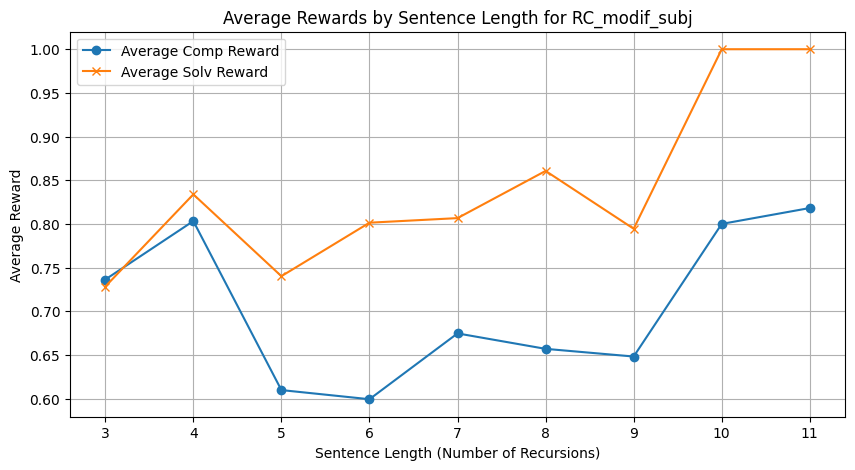

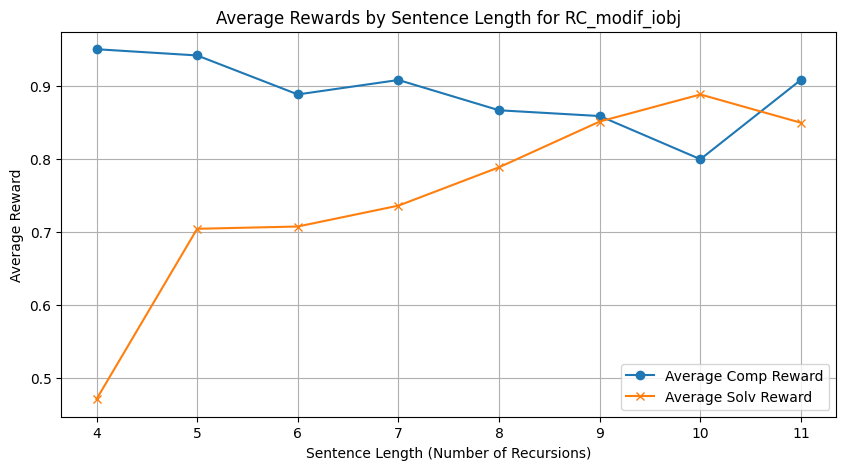

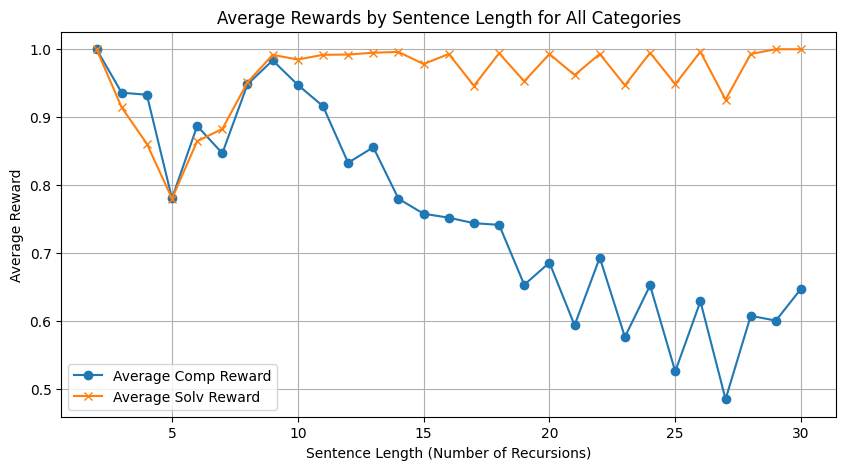

In [46]:
# Create graphs of average comp reward and solv reward by sentence length
def plot_average_rewards(df, category_name):
    # Calculate average rewards by sentence length
    # Use the length of bottom_idx as sentence length
    df = df.copy()
    df['sent_len'] = df['bottom_idx'].apply(len)
    avg_comp_reward = df.groupby('sent_len')['comp reward'].mean()
    avg_solv_reward = df.groupby('sent_len')['solv reward'].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(avg_comp_reward.index, avg_comp_reward.values, label='Average Comp Reward', marker='o')
    plt.plot(avg_solv_reward.index, avg_solv_reward.values, label='Average Solv Reward', marker='x')
    plt.title(f'Average Rewards by Sentence Length for {category_name}')
    plt.xlabel('Sentence Length (Number of Recursions)')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_rewards(df_rc_modif_subj, 'RC_modif_subj')
plot_average_rewards(df_rc_modif_iobj, 'RC_modif_iobj')
plot_average_rewards(df, 'All Categories')


In [48]:
df['sent_len'] = df['bottom_idx'].apply(len)
# show the 20 longest sentences in the dataset
longest_sentences = df.nlargest(20, 'sent_len')
print("\n20 Longest Sentences in the Dataset:")
print(longest_sentences[['pair', 'sent_len']])


20 Longest Sentences in the Dataset:
                                                    pair  sent_len
1203   [aiden liked that scarlett appreciated that av...        30
5082   [a child confessed that the duke liked that a ...        30
7163   [the chicken confessed that the princess thoug...        30
1715   [samuel admired that a goose hoped that the ch...        29
2244   [emma liked that the girl meant that zoey said...        29
3383   [the bird expected that ethan confessed that a...        29
7570   [a baby meant that noah liked that caleb said ...        29
9653   [the girl liked that ava wished that the boy p...        29
10624  [thomas declared that a girl liked that a king...        29
12829  [emma liked that luke noticed that asher hoped...        29
244    [alexander liked that a girl liked that ava su...        28
298    [logan liked that the crocodile hoped that har...        28
881    [ava appreciated that the cow liked that emma ...        28
1092   [harper confessed

In [40]:
# Now, create a df for "Q_long_mv"
df_q_lmv = df[df['category'] == 'Q_long_mv'].copy()

# create new column called "hit" that is true if both "comp reward" and "solv reward" are 1
df_q_lmv['hit'] = (df_q_lmv['comp reward'] == 1) & (df_q_lmv['solv reward'] == 1)

# create a new column called "word_array" that is the first element of "pair" split by spaces
df_q_lmv['word_array'] = df_q_lmv['pair'].apply(lambda x: x[0].split())

# now, create a new column called "sel_word" that takes the first index in bottom_idx and pulls that word from word_array
df_q_lmv['sel_word'] = df_q_lmv.apply(lambda row: row['word_array'][row['bottom_idx'][-1]] if row['bottom_idx'] else None, axis=1)

# now, print the mean of hit for each unique value in sel_word
mean_hit_by_word = df_q_lmv.groupby('sel_word')['hit'].mean().reset_index()
mean_hit_by_word = mean_hit_by_word.sort_values(by='hit', ascending=False)
print("\nMean hit rate by selected word in Q_long_mv:")
print(mean_hit_by_word)


Mean hit rate by selected word in Q_long_mv:
         sel_word       hit
14  disintegrated  0.500000
32           knew  0.333333
0         admired  0.250000
46            saw  0.200000
55      tolerated  0.181818
5          burned  0.166667
52        stabbed  0.166667
49           slid  0.153846
17         dusted  0.142857
2     appreciated  0.142857
6          called  0.125000
39         packed  0.100000
21          found  0.100000
22          froze  0.083333
31        juggled  0.062500
23           grew  0.058824
47      shortened  0.052632
45         rolled  0.049587
40        painted  0.041667
26         helped  0.040816
16           drew  0.040000
33          liked  0.027397
3             ate  0.008264
44      respected  0.000000
41        pierced  0.000000
42          poked  0.000000
43       reddened  0.000000
56         tossed  0.000000
57        touched  0.000000
48       sketched  0.000000
37         nursed  0.000000
50        snapped  0.000000
58         valued  0.000000
51

In [41]:
# create two new columns for df, one called "unlab_pred_edges" and another "unlab_gold_edges". They both contains their respective values from "pred_edges" and "gold_edges" but without the third element of every element

df['unlab_pred_edges'] = df['pred_edges'].apply(lambda x: [edge[:2] for edge in x])
df['unlab_gold_edges'] = df['gold_edges'].apply(lambda x: [edge[:2] for edge in x])

# now, create a new column called "pred_set" and "gold_set" that contains the set of words in any position of the edges
df['pred_set'] = df['unlab_pred_edges'].apply(lambda x: set([word for edge in x for word in edge]))
df['gold_set'] = df['unlab_gold_edges'].apply(lambda x: set([word for edge in x for word in edge]))

# now, create a new column that contains any difference between the two sets, whether it is in pred_set or gold_set
df['diff_set'] = df.apply(lambda row: row['pred_set'].symmetric_difference(row['gold_set']), axis=1)

# now print all rows where the diff_set is not empty
non_empty_diff = df[df['diff_set'].apply(lambda x: len(x) > 0)]
non_empty_diff[['pair', 'pred_set', 'gold_set', 'diff_set']]

# now construct a set of all unique words in the diff_set
unique_diff_words = set()
for diff in non_empty_diff['diff_set']:
    unique_diff_words.update(diff)

print(unique_diff_words)

# print the proportion fo records where the diff_set is not empty
proportion_non_empty_diff = len(non_empty_diff) / len(df)
print(f"Proportion of records with non-empty diff_set: {proportion_non_empty_diff:.2%}")

{'imagine', 'support', 'mean'}
Proportion of records with non-empty diff_set: 0.32%
